In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [4]:
hist_df = pd.read_csv('/historical_data.csv')
sentiment_df = pd.read_csv('/fear_greed_index.csv')

In [5]:
hist_df['Timestamp IST'] = pd.to_datetime(hist_df['Timestamp IST'], dayfirst=True)
hist_df['date'] = hist_df['Timestamp IST'].dt.date


In [6]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

In [7]:
daily_behavior = hist_df.groupby('date').agg(
    daily_pnl=('Closed PnL', 'sum'),
    daily_volume=('Size USD', 'sum'),
    trade_count=('Trade ID', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    risk_volatility=('Closed PnL', 'std')
).reset_index().fillna(0)

In [8]:
df = pd.merge(daily_behavior, sentiment_df[['date', 'value', 'classification']], on='date', how='inner')
df.rename(columns={'value': 'sentiment_score'}, inplace=True)

In [9]:
print("=== ALIGNMENT: TRADING BEHAVIOR vs MARKET SENTIMENT ===")
for metric in ['daily_pnl', 'daily_volume', 'trade_count', 'avg_trade_size', 'risk_volatility']:
    corr, _ = pearsonr(df[metric], df['sentiment_score'])
    print(f"Sentiment vs {metric.replace('_', ' ').title()}: {corr:.3f}")

=== ALIGNMENT: TRADING BEHAVIOR vs MARKET SENTIMENT ===
Sentiment vs Daily Pnl: -0.083
Sentiment vs Daily Volume: -0.264
Sentiment vs Trade Count: -0.245
Sentiment vs Avg Trade Size: -0.052
Sentiment vs Risk Volatility: -0.067


In [11]:
df['BUY_SIGNAL'] = (df['sentiment_score'] < 25) & (df['daily_volume'] > df['daily_volume'].median())

In [13]:
df['SELL_SIGNAL'] = (df['sentiment_score'] > 75) & (df['daily_pnl'] < 0)

print(f"\n🚀 HIDDEN SIGNALS:")
print(f"Strategic Buy Opportunities (Panic in Market): {df['BUY_SIGNAL'].sum()}")
print(f"Greed Trap Warnings (Late Entry/FOMO Losses): {df['SELL_SIGNAL'].sum()}")


🚀 HIDDEN SIGNALS:
Strategic Buy Opportunities (Panic in Market): 10
Greed Trap Warnings (Late Entry/FOMO Losses): 5


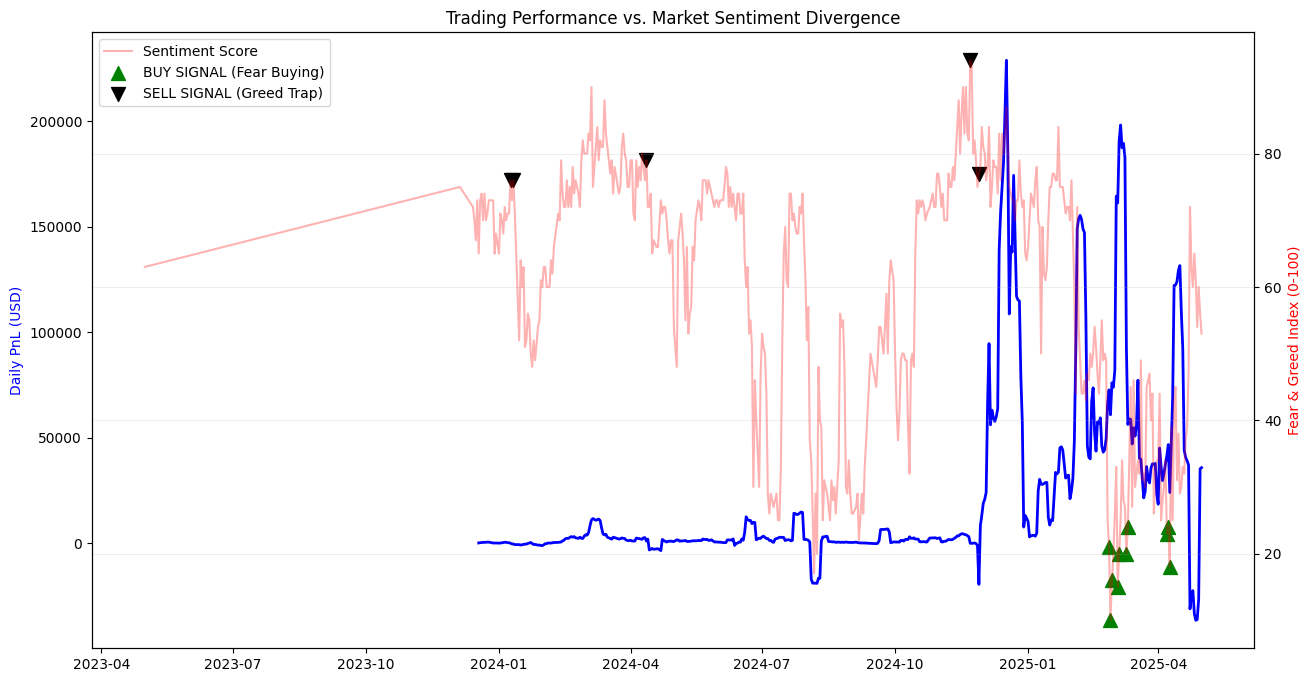

In [15]:

plt.figure(figsize=(15, 8))


ax1 = plt.gca()
ax2 = ax1.twinx()


ax1.plot(df['date'], df['daily_pnl'].rolling(7).mean(), color='blue', label='7-Day Avg PnL', linewidth=2)
ax2.plot(df['date'], df['sentiment_score'], color='red', alpha=0.3, label='Sentiment Score')

plt.scatter(df['date'][df['BUY_SIGNAL']], df['sentiment_score'][df['BUY_SIGNAL']],
            color='green', marker='^', s=100, label='BUY SIGNAL (Fear Buying)')
plt.scatter(df['date'][df['SELL_SIGNAL']], df['sentiment_score'][df['SELL_SIGNAL']],
            color='black', marker='v', s=100, label='SELL SIGNAL (Greed Trap)')

ax1.set_ylabel('Daily PnL (USD)', color='blue')
ax2.set_ylabel('Fear & Greed Index (0-100)', color='red')
plt.title('Trading Performance vs. Market Sentiment Divergence')
plt.legend(loc='upper left')
plt.grid(alpha=0.2)
plt.show()

In [16]:

from sklearn.ensemble import RandomForestRegressor

In [17]:
behavior = hist_df.groupby('date').agg(
    pnl=('Closed PnL', 'sum'),
    volume=('Size USD', 'sum'),
    risk=('Closed PnL', 'std'),

    leverage_proxy=('Size USD', lambda x: x.sum() / hist_df['Size USD'].median())
).reset_index().fillna(0)


In [18]:
df = pd.merge(behavior, sentiment_df[['date', 'value']], on='date', how='inner')

In [19]:
df['sentiment_lag'] = df['value'].shift(1)
df = df.dropna()

In [20]:
X = df[['value', 'volume', 'leverage_proxy', 'risk']]
y = df['pnl']

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

RandomForestRegressor()

In [21]:
print("=== WHAT INFLUENCES YOUR PROFITABILITY? ===")
for name, imp in zip(X.columns, rf.feature_importances_):
    print(f"{name.replace('_', ' ').title()}: {imp:.2%}")

=== WHAT INFLUENCES YOUR PROFITABILITY? ===
Value: 10.13%
Volume: 17.19%
Leverage Proxy: 17.31%
Risk: 55.37%


In [22]:
df['signal'] = np.where((df['value'] < 30) & (df['leverage_proxy'] < df['leverage_proxy'].mean()), "SMART BUY", "WAIT")


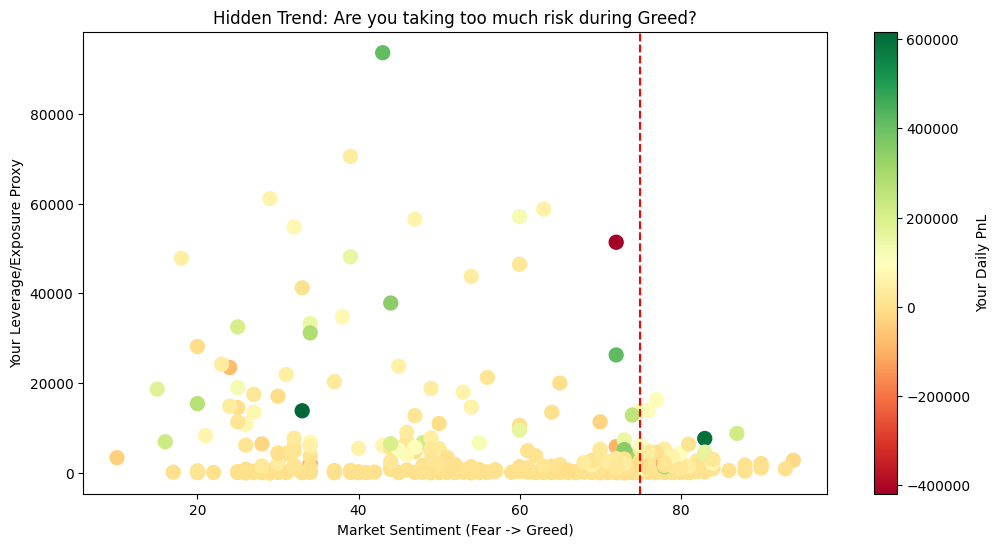

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(df['value'], df['leverage_proxy'], c=df['pnl'], cmap='RdYlGn', s=100)
plt.colorbar(label='Your Daily PnL')
plt.xlabel('Market Sentiment (Fear -> Greed)')
plt.ylabel('Your Leverage/Exposure Proxy')
plt.title('Hidden Trend: Are you taking too much risk during Greed?')
plt.axvline(75, color='red', linestyle='--', label='Extreme Greed Zone')
plt.show()